# EECE5644 - Assignment 1
### Anthony Lee

# Question 1

## Part A

In [1]:
import time # Importing to time the different LS approaches

import matplotlib.pyplot as plt # For general plotting
from sys import float_info
from matplotlib import cm
from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix
plt.rcParams['legend.fontsize'] = '24'

import numpy as np
import pandas as pd

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title



\begin{equation*}
\frac{g(x|m_{0},C_{0})}{g(x|m_{1},C_{1})} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} 1.857 \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})}
\end{equation*}

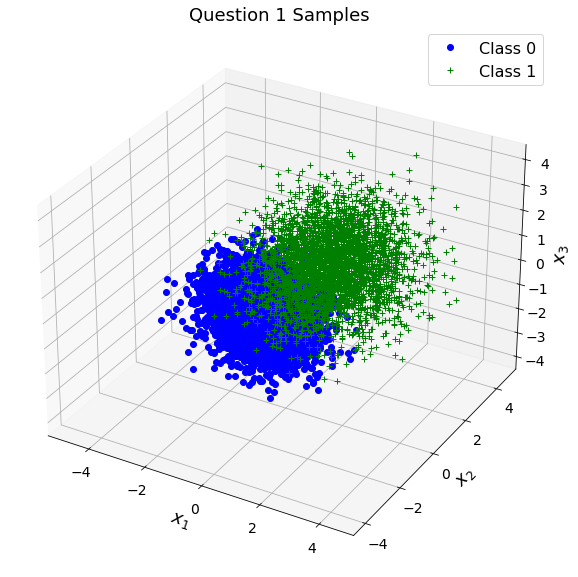

In [2]:
# number of samples
N = 10000

np.random.seed(7)


# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[-0.5, -0.5, -0.5],
              [1, 1, 1]])

Sigma = np.array([[[1, -0.5, 0.3],
               [-0.5, 1, -0.5],
               [0.3, -0.5, 1]],
              [[1, 0.3, -0.2],
               [0.3, 1, 0.3],
               [-0.2, 0.3, 1]]])

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.65, 0.35])

C = len(priors)
# Decide randomly which samples will come from each component (taking class 1 from standard normal values above 0.35)
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C))
Nl = np.array([sum(labels == l) for l in L])

# Draw samples from each class pdf
X = np.zeros((N, n))
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])


# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
popPlt = plt.axes(projection = '3d')
popPlt.plot(X[labels==0, 0], X[labels==0, 1], X[labels==0, 2], 'bo', label="Class 0")
popPlt.plot(X[labels==1, 0], X[labels==1, 1], X[labels==1, 2], 'g+', label="Class 1")

plt.legend()
popPlt.set_xlabel(r"$x_1$")
popPlt.set_ylabel(r"$x_2$")
popPlt.set_zlabel(r"$x_3$")
plt.title("Question 1 Samples")
plt.show()

In [3]:
def estimate_roc(likelihood_ratios, labels, Nl, priors):
    sorted_score = sorted(likelihood_ratios)
    taus = ([sorted_score[0] - float_info.epsilon] + 
             sorted_score +
             [sorted_score[-1] + float_info.epsilon])
    
    nt = len(taus)

    true_positive = np.zeros(nt)
    false_positive = np.zeros(nt)
    true_negative = np.zeros(nt)
    false_negative = np.zeros(nt)

    # retrieve probability list
    for i in range(nt):
        decisions = likelihood_ratios >= taus[i]
        true_positive[i] = len(np.argwhere((labels == 1) & (decisions == 1))) / Nl[1]
        false_positive[i] = len(np.argwhere((labels == 0) & (decisions == 1))) / Nl[0]
        true_negative[i] = len(np.argwhere((labels == 0) & (decisions == 0))) / Nl[0]
        false_negative[i] = len(np.argwhere((labels == 1) & (decisions == 0))) / Nl[1]

    # calculate and print perror
    perrors = false_positive.dot(priors[0]) + false_negative.dot(priors[1])
    minerror_index = np.argmin(perrors)
    print("Minimum p-error: {:0.4f}".format(perrors[minerror_index]))
    print("Occurs at threshold: {:0.4f}".format(taus[minerror_index].real))


    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(false_positive, true_positive)
    plt.plot(false_positive[minerror_index], true_positive[minerror_index], 'rx', label="Minimum P(Error) MAP", markersize=16)
    plt.legend()
    plt.xlabel(r"Probability of false alarm $P(D=1|L=0)$")
    plt.ylabel(r"Probability of correct decision $P(D=1|L=1)$")
    plt.title("ROC Curve")
    plt.grid()

True Data ERM Classification
Minimum p-error: 0.0557
Occurs at threshold: 1.6232


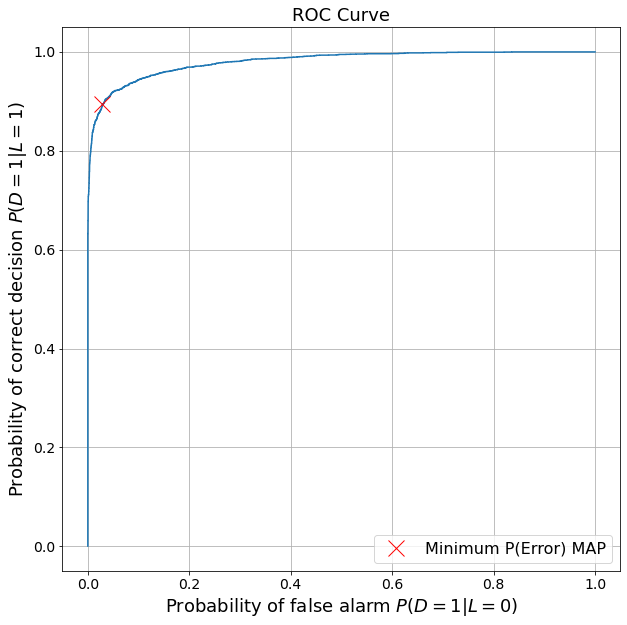

In [4]:
print("True Data ERM Classification")
class_cond_llds = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
lld_ratios = np.array(class_cond_llds[1]/class_cond_llds[0])
estimate_roc(lld_ratios, labels, Nl, priors)

## Part B

Naive Bayesian Classifier
Minimum p-error: 0.0671
Occurs at threshold: 1.1136


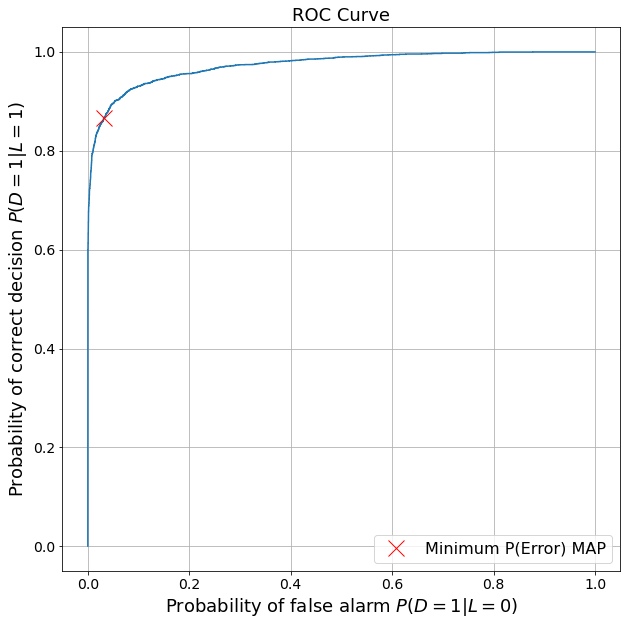

In [5]:
print("Naive Bayesian Classifier")
naive_bayes_sigma = np.zeros((2, 3, 3))
naive_bayes_sigma[0] = np.diag(np.ones(3))
naive_bayes_sigma[1] = np.diag(np.ones(3))
class_cond_llds = np.array([multivariate_normal.pdf(X, mu[l], naive_bayes_sigma[l]) for l in L])
lld_ratios = np.array(class_cond_llds[1]/class_cond_llds[0])
estimate_roc(lld_ratios, labels, Nl, priors)

In [6]:
def perform_lda(X, labels, C=2, plot_vec=True):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).
    Note: you can generalize this implementation to multiple classes by finding a
    projection matrix W (rather than vector) that reduces dimensionality n inputs
    to a multidimensional projection z=W'*x (e.g. z of dimension C-1). Now we have
    a crude but quick way of achieving class-separability-preserving linear dimensionality
    reduction using the Fisher LDA objective as a measure of class separability.
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        labels: Class labels per sample received as an [N, 1] column.
        C: Number classes, explicitly clarifying that we're doing binary classification here.
        plot_vec: If you want the option of directly plotting the linear projection vector over your input space.
    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """

    # Estimate mean vectors and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]
    # Extract corresponding sorted eigenvectors
    U = U[:, idx]
    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    # If using sklearn instead:
    # lda = LinearDiscriminantAnalysis()
    # X_fit = lda.fit(X, labels)  # Is a fitted estimator, not actual data to project
    # z = lda.transform(X)
    # w = X_fit.coef_[0]

    if plot_vec:
        # All the variables we need to get set for plotting
        mid_point = (mu[0] + mu[1]) / 2
        slope = w[1] / w[0]
        c = mid_point[1] - slope * mid_point[0]

        xmax = np.max(X[:, 0])
        xmin = np.min(X[:, 0])
        x = np.linspace(xmin + 1, xmax + 1, 100)

        fig = plt.figure(figsize=(12, 12))

        x0 = X[labels == 0]
        x1 = X[labels == 1]
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(x0[:, 0], x0[:, 1], 'b.', x1[:, 0], x1[:, 1], 'r+')
        ax1.plot(x, slope * x + c, c='orange')
        ax1.legend(["C0", "C1", "wLDA"])

        ax2 = fig.add_subplot(2, 1, 2)
        z0 = z[labels == 0]
        z1 = z[labels == 1]
        ax2.plot(z0, np.zeros(len(z0)), 'b.', z1, np.zeros(len(z1)), 'r+')
        plt.show()

    return w, z

C:\Users\anton\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\anton\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


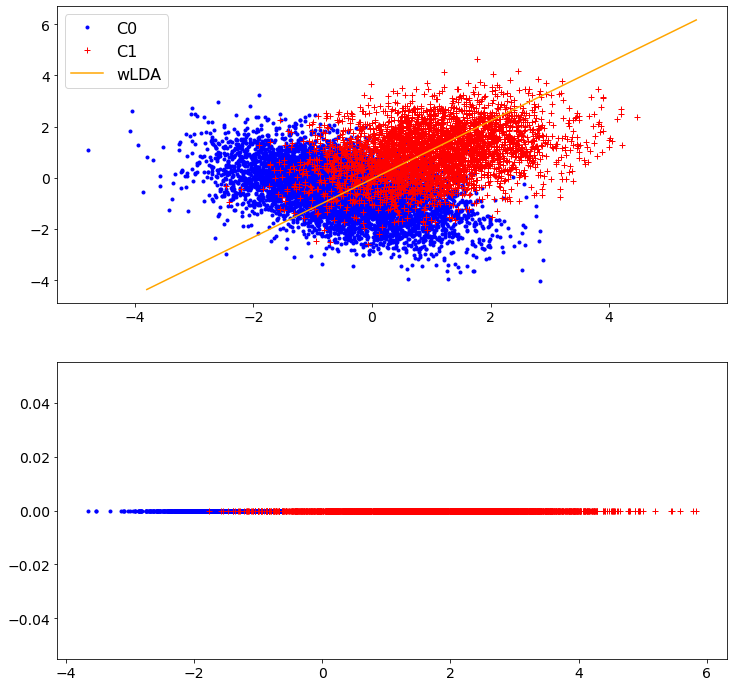

Minimum p-error: 0.0651
Occurs at threshold: 0.3229


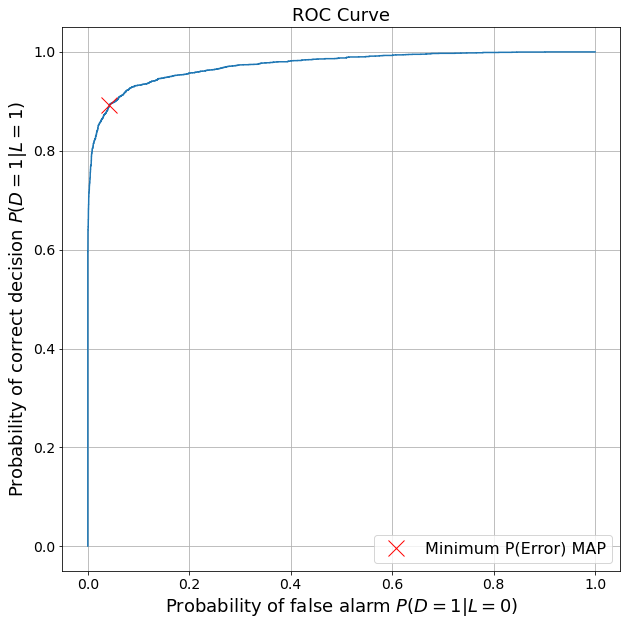

In [7]:
w, z = perform_lda(X, labels)
estimate_roc(z.real, labels, Nl, priors)

# Question 2

## Part A

In [8]:
def display_decisions(X, decisions, labels, L):
    decision_counts = np.array([sum(decisions == l) for l in L])
    label_counts = np.array([sum(labels == l) for l in L])
    print("Decisions matrix: ", decisions)
    print("Correct: ", labels)
    print("Counts of class sample: Class 1 = {}, Class 2 = {}, Class 3 = {}, Class 4 = {}".format(
        label_counts[0], label_counts[1], label_counts[2], label_counts[3]))
    print("Counts of decisions: Class 1 = {}, Class 2 = {}, Class 3 = {}, Class 4 = {}".format(
        decision_counts[0], decision_counts[1], decision_counts[2], decision_counts[3]))
    
    print("Confusion matrix: ")
    conf_matrix = confusion_matrix(decisions, labels)
    print(conf_matrix)

    correct_sample_count = np.sum(np.diag(conf_matrix))
    prob_error = 1 - correct_sample_count / N
    print("Error probability: {:.4f}".format(prob_error))

    # Plot for decisions vs true labels
    fig = plt.figure(figsize=(10, 10))
    marker_shapes = '.o^s'
    for l in L:
        correct_ind = np.argwhere((labels == l) & (decisions == labels))
        incorrect_ind = np.argwhere((labels == l) & (decisions != labels))
        plt.plot(X[correct_ind, 0], X[correct_ind, 1], marker_shapes[l-1] + 'g', label="Correct Predicted Class {}".format(l), zorder=0)
        plt.plot(X[incorrect_ind, 0], X[incorrect_ind, 1], marker_shapes[l-1] + 'r', label="Incorrect Predicted Class {}".format(l), zorder=1)
    
    plt.legend()
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title("Correct and Incorrect ERM Classifications")
    plt.tight_layout()

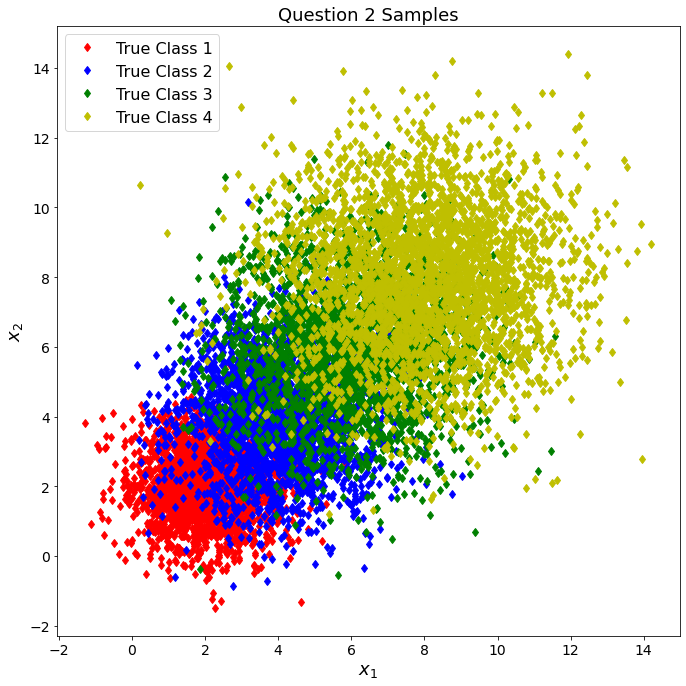

In [9]:
mu = np.array([[2, 2],
               [4, 4],
               [6, 6],
               [8, 8]])
Sigma = np.array([[[1, 0], [0, 1]], 
                  [[2, 0], [0, 2]],
                  [[3, 0], [0, 3]],
                  [[4, 0], [0, 4]]])
priors = np.array([0.2, 0.25, 0.25, 0.3])
L = np.array([1, 2, 3, 4])
n = mu.shape[1]

u = np.random.rand(N) 
thresholds = np.cumsum(priors) # thresholds for the sample labels
thresholds = np.insert(thresholds, 0, 0)

labels = np.zeros(N) # true labels
X = np.zeros((N, n)) # samples

fig = plt.figure(figsize=(10, 10))
marker_shapes = 'dddd'
marker_colors = 'rbgy'

for l in L:
    # get true class labels
    indices = np.argwhere((thresholds[l-1] <= u) & (u < thresholds[l]))[:, 0]
    Nl = len(indices)
    labels[indices] = l * np.ones(Nl)

    # get samples from multivariate normal distribution and plot
    X[indices, :] = multivariate_normal.rvs(mu[l-1], Sigma[l-1], Nl)

    plt.plot(X[indices, 0], X[indices, 1], marker_shapes[l-1] + marker_colors[l-1], label="True Class {}".format(l))

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Question 2 Samples")
plt.tight_layout()
plt.show()

Decisions matrix:  [4. 1. 4. ... 4. 3. 3.]
Correct:  [4. 1. 4. ... 4. 3. 3.]
Counts of class sample: Class 1 = 2009, Class 2 = 2506, Class 3 = 2456, Class 4 = 3029
Counts of decisions: Class 1 = 2123, Class 2 = 2614, Class 3 = 2296, Class 4 = 2967
Confusion matrix: 
[[1817  296    9    1]
 [ 192 1863  514   45]
 [   0  343 1347  606]
 [   0    4  586 2377]]
Error probability: 0.2596


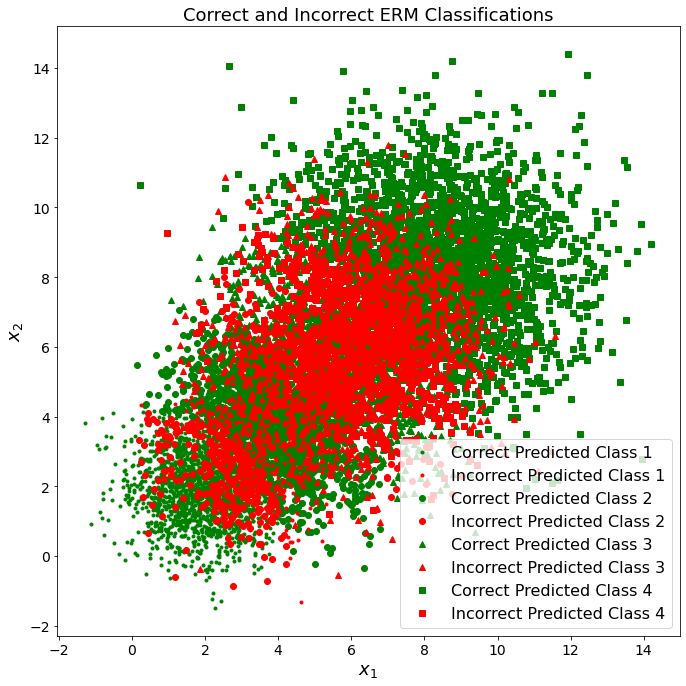

In [10]:
# retrieve posterior probability matrix
class_cond_llds = np.array([multivariate_normal.pdf(X, mu[l-1], Sigma[l-1]) for l in L])
class_priors = np.diag(priors)
class_posteriors = class_priors.dot(class_cond_llds)

# MAP decision rule
decisions = np.argmax(class_posteriors, axis=0) + np.ones(N)
display_decisions(X, decisions, labels, L)


## Part B

Decisions matrix:  [4. 1. 4. ... 4. 3. 3.]
Correct:  [4. 1. 4. ... 4. 3. 3.]
Counts of class sample: Class 1 = 2009, Class 2 = 2506, Class 3 = 2456, Class 4 = 3029
Counts of decisions: Class 1 = 2094, Class 2 = 2557, Class 3 = 2408, Class 4 = 2941
Confusion matrix: 
[[1805  279    9    1]
 [ 204 1843  471   39]
 [   0  380 1403  625]
 [   0    4  573 2364]]
Error probability: 0.2585
Minimum expected risk: 0.00410


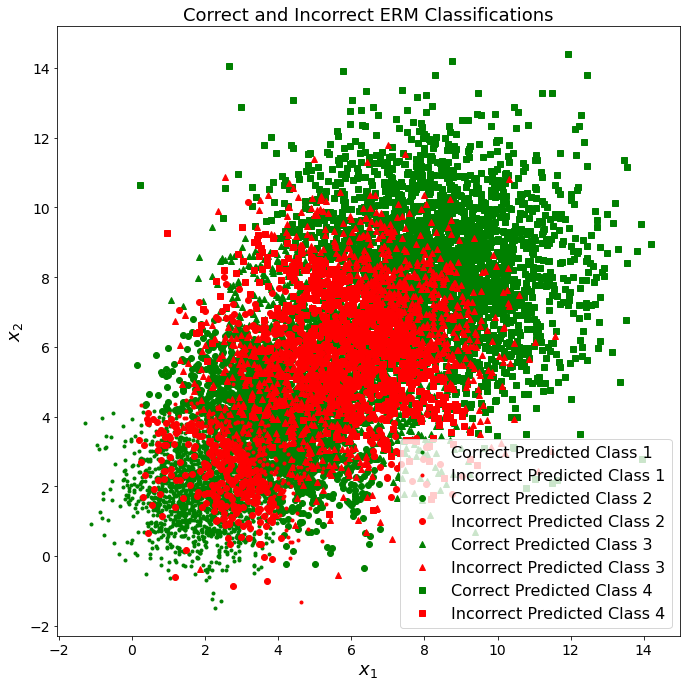

In [11]:
# decision rule for new loss values
Lambda = np.array([[0, 1, 2, 3],
                   [1, 0, 1, 2],
                   [2, 1, 0, 1],
                   [3, 2, 1, 0]])

# use posterior values from part A and adjust for new losses
class_expected_risk = Lambda.dot(class_posteriors)

# implement erm classification
decisions = np.argmin(class_expected_risk, axis=0) + np.ones(N)
display_decisions(X, decisions, labels, L)

# calculate expected loss
chosen_risks = [class_expected_risk[int(decisions[i]) - 1, i] for i in range(N)]
cum_loss = np.sum(chosen_risks)
expected_loss = cum_loss / N
print("Minimum expected risk: {:0.5f}".format(expected_loss))

plt.show()

# Question 3

In [12]:
def display_decision_stats(X, decisions, labels, L):
    decision_counts = np.array([sum(decisions == l) for l in L])
    label_counts = np.array([sum(labels == l) for l in L])
    print("Decisions matrix: ", decisions)
    print("Correct labels: ", labels)
    print("Real sample counts: ", label_counts)
    print("Decision counts: ", decision_counts)
    
    conf_mat = confusion_matrix(decisions, labels)
    print("Confusion matrix: ")
    print(conf_mat)

    correct_sample_count = np.sum(np.diag(conf_mat))
    prob_error = 1 - correct_sample_count / X.shape[0]
    print("Error count: ", X.shape[0] - correct_sample_count)
    print("Error probability: {:.4f}".format(prob_error))

In [13]:
def data_parameters(features, labels, label_set):
    N = features.shape[0]
    feature_count = features.shape[1]
    class_count = len(label_set) # label count
    print("Sample count: ", N)
    print("Feature count: ", feature_count)
    print("Label set: ", label_set)

    # seperate data into lists
    class_features = []
    for i in range(class_count):
        class_features.append([])
    for i in range(N):
        class_features[np.where(label_set == labels[i])[0][0]].append(features[i])
    
    # find info on class-seperated sample array
    priors = np.zeros(class_count)
    mu = np.zeros((class_count, feature_count))
    Sigma = np.zeros((class_count, feature_count, feature_count))
    for i in range(class_count):
        if len(class_features[i]) == 0:
            continue
        cf = np.array(class_features[i])
        priors[i] = len(cf) / N
        mu[i] = np.sum(cf, 0) / len(cf)
        Sigma[i] = np.cov(cf.T)

    print("Priors: ", priors)
    print("Mean matrix: ", mu.shape)
    print(mu)
    print("Covariance matrix: ", Sigma.shape)
    print(Sigma)

    return priors, mu, Sigma

In [14]:
def classify_min_perror(data, priors, mu, sigma, class_count):
    class_conditional_likelihoods = np.array([multivariate_normal.pdf(data, mu[c], sigma[c]) for c in range(class_count)])
    class_priors = np.diag(priors)
    class_posteriors = class_priors.dot(class_conditional_likelihoods)

    decisions = np.argmax(class_posteriors, axis=0)
    return decisions

In [15]:
# function to regularize matrix
def regularize(sigma, alpha):
    sigma_reg = np.zeros(sigma.shape)
    for i in range(len(sigma)):
        rank = np.linalg.matrix_rank(sigma[i])
        reg_param = alpha
        if rank != 0:
            reg_param = alpha * np.trace(sigma[i]) / rank
        sigma_reg[i] = sigma[i] + reg_param * np.diag(np.ones(sigma[i].shape[0]))
    return sigma_reg

In [16]:
def perform_pca(X):
    """  Principal Component Analysis (PCA) on real-valued vector data.
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
    Returns:
        U: An orthogonal matrix [n, n] that contains the PCA projection vectors, ordered from first to last.
        D: A diagonal matrix [n, n] that contains the variance of each PC corresponding to the projection vectors.
        Z: PC projection matrix of the zero-mean input samples, shape [N, n].
    """

    # First derive sample-based estimates of mean vector and covariance matrix:
    mu = np.mean(X, axis=0)
    sigma = np.cov(X.T)

    # Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
    C = X - mu

    # Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
    lambdas, U = np.linalg.eig(sigma)
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]
    # Extract corresponding sorted eigenvectors and eigenvalues
    U = U[:, idx]
    D = np.diag(lambdas[idx])

    # PC projections of zero-mean samples, U^Tx (x mean-centred), matrix over N is XU
    Z = C.dot(U)

    # If using sklearn instead:
    # pca = PCA(n_components=X.shape[1])  # n_components is how many PCs we'll keep... let's take all of them
    # X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
    # Z = pca.transform(X)

    return U, D, Z

In [17]:
df = pd.read_csv("winequality-white.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [18]:
# read data and convert to numpy array
wine_data = pd.read_csv("winequality-white.csv").to_numpy()

wine_classes = wine_data[:, -1]
wine_data = np.delete(wine_data, -1, 1)

wine_labelset = np.linspace(0, 10, 11)
wine_priors, wine_mu, wine_sigma = data_parameters(wine_data, wine_classes, wine_labelset)
wine_sigma_reg = regularize(wine_sigma, 0.000009)

wine_decisions = classify_min_perror(wine_data, wine_priors, wine_mu, wine_sigma_reg, 11)
display_decision_stats(wine_data, wine_decisions, wine_classes, wine_labelset)





Sample count:  4898
Feature count:  11
Label set:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Priors:  [0.         0.         0.         0.0040833  0.03327889 0.29746835
 0.44875459 0.17966517 0.03572887 0.00102082 0.        ]
Mean matrix:  (11, 11)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.60000000e+00 3.33250000e-01 3.36000000e-01 6.39250000e+00
  5.43000000e-02 5.33250000e+01 1.70600000e+02 9.94884000e-01
  3.18750000e+00 4.74500000e-01 1.03450000e+01]
 [7.12944785e+00 3.81226994e-01 3.04233129e-01 4.62822086e+

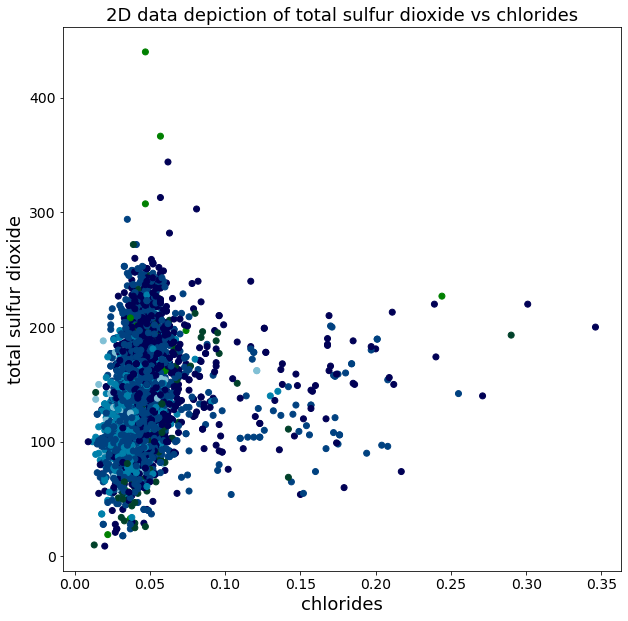

In [19]:
# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.scatter(wine_data[:, 4], wine_data[:, 6], c = wine_classes, cmap = "ocean")

plt.xlabel("chlorides")
plt.ylabel("total sulfur dioxide")
plt.title("2D data depiction of total sulfur dioxide vs chlorides")
plt.show()

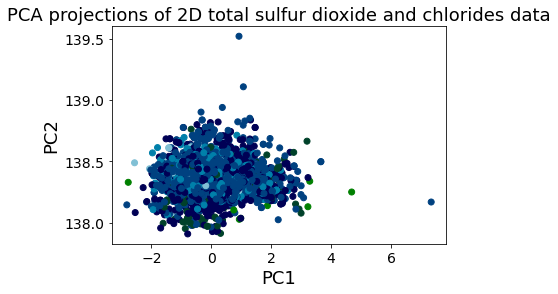

In [20]:
_, _, Z = perform_pca(wine_data)
wine_data_pca = Z + np.mean(wine_data, axis=0)

plt.scatter(wine_data_pca[:, 4], wine_data_pca[:, 6], c = wine_classes, cmap = "ocean")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projections of 2D total sulfur dioxide and chlorides data")
plt.show()

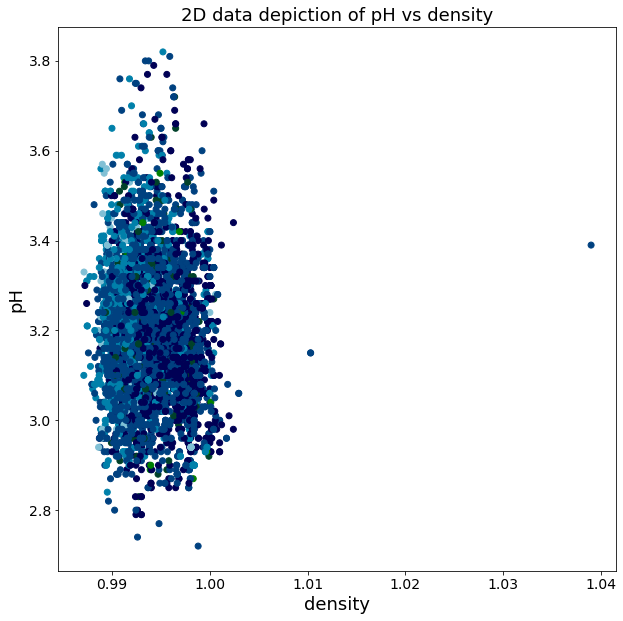

In [21]:
# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.scatter(wine_data[:, 7], wine_data[:, 8], c = wine_classes, cmap = "ocean")

plt.xlabel("density")
plt.ylabel("pH")
plt.title("2D data depiction of pH vs density")
plt.show()

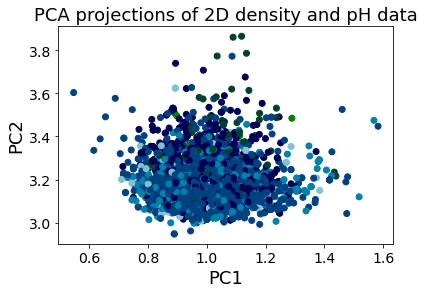

In [22]:
_, _, Z = perform_pca(wine_data)
wine_data_pca = Z + np.mean(wine_data, axis=0)

plt.scatter(wine_data_pca[:, 7], wine_data_pca[:, 8], c = wine_classes, cmap = "ocean")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projections of 2D density and pH data")
plt.show()

In [23]:
human_features = []
human_labels = []
with open("X_train.txt", "r") as f:
    human_features = f.readlines()
with open("X_test.txt", "r") as f:
    human_features.extend(f.readlines())
with open("y_train.txt", "r") as f:
    human_labels = f.readlines()
with open("y_test.txt", "r") as f:
    human_labels.extend(f.readlines())
    
human_features = np.array([[float(num) for num in f.split()] for f in human_features]) 
human_labels = np.array([int(l) for l in human_labels]) 
human_labelset = np.linspace(1, 6, 6)
human_priors, human_mu, human_sigma = data_parameters(human_features, human_labels, human_labelset)
human_sigma_reg = regularize(human_sigma, 0.24)
print(human_sigma_reg)

human_decisions = classify_min_perror(human_features, human_priors, human_mu, human_sigma_reg, 6)
human_decisions = human_decisions + np.ones(len(human_decisions))
display_decision_stats(human_features, human_decisions, human_labels, human_labelset)

Sample count:  10299
Feature count:  561
Label set:  [1. 2. 3. 4. 5. 6.]
Priors:  [0.1672007  0.14991747 0.13651811 0.17254102 0.18506651 0.18875619]
Mean matrix:  (6, 561)
[[ 0.27633688 -0.01790683 -0.10888169 ... -0.76188622  0.21859934
   0.05977064]
 [ 0.26229465 -0.02592329 -0.12053793 ... -0.63798014  0.27864194
   0.1227938 ]
 [ 0.28813723 -0.01631193 -0.10576162 ... -0.78087312  0.20018859
   0.05586593]
 [ 0.27305961 -0.01268957 -0.105517   ... -0.70604182  0.00613979
  -0.08953195]
 [ 0.27915349 -0.01615189 -0.10658691 ... -0.77414276  0.20981843
   0.03174291]
 [ 0.26864864 -0.01831773 -0.10743563 ...  0.52026113 -0.43594428
  -0.42774882]]
Covariance matrix:  (6, 561, 561)
[[[ 2.44612909e-03  9.11530670e-06 -1.29152685e-04 ... -5.27339859e-05
   -2.28929354e-05 -1.16936019e-04]
  [ 9.11530670e-06  4.22226463e-04  9.18078107e-05 ... -2.04621790e-05
    1.97661936e-05 -9.03647580e-05]
  [-1.29152685e-04  9.18078107e-05  1.01085309e-03 ...  2.74001744e-05
    5.12017661e-05  6

C:\Users\anton\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:526: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))


Decisions matrix:  [5. 5. 5. ... 2. 2. 2.]
Correct labels:  [5 5 5 ... 2 2 2]
Real sample counts:  [1722 1544 1406 1777 1906 1944]
Decision counts:  [1838 1997  842  944 2735 1943]
Confusion matrix: 
[[1720    0  113    0    5    0]
 [   1 1544  452    0    0    0]
 [   1    0  841    0    0    0]
 [   0    0    0  942    1    1]
 [   0    0    0  835 1900    0]
 [   0    0    0    0    0 1943]]
Error count:  1409
Error probability: 0.1368


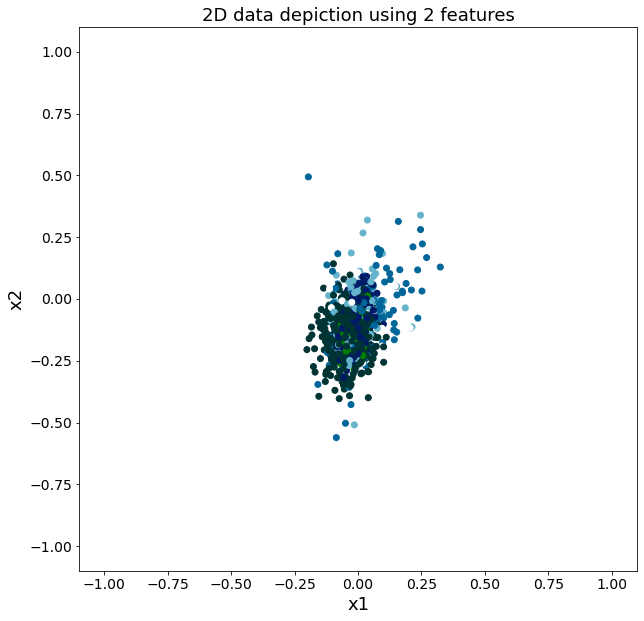

In [24]:
# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.scatter(human_features[:, 1], human_features[:, 2], c = human_labels, cmap = "ocean")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("2D data depiction using 2 features")
plt.show()

C:\Users\anton\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


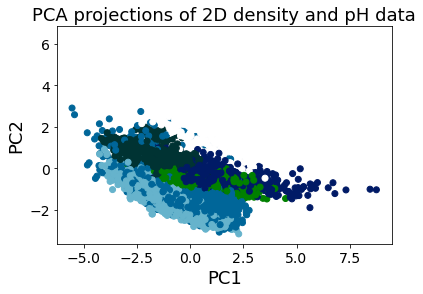

In [25]:
_, _, Z = perform_pca(human_features)
human_features_pca = Z + np.mean(human_features, axis=0)

plt.scatter(human_features_pca[:, 1], human_features_pca[:, 2], c = human_labels, cmap = "ocean")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projections of 2D density and pH data")
plt.show()

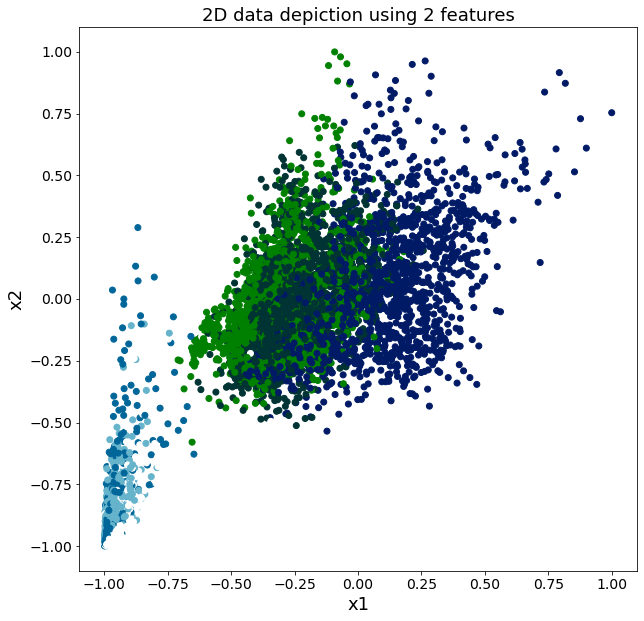

In [26]:
# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.scatter(human_features[:, 3], human_features[:, 4], c = human_labels, cmap = "ocean")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("2D data depiction using 2 features")
plt.show()

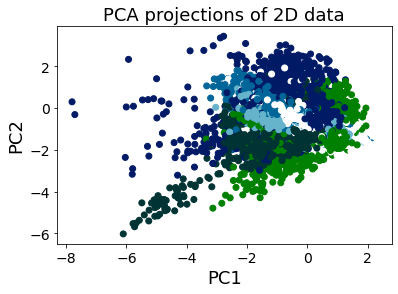

In [27]:
_, _, Z = perform_pca(human_features)
human_features_pca = Z + np.mean(human_features, axis=0)

plt.scatter(human_features_pca[:, 3], human_features_pca[:, 4], c = human_labels, cmap = "ocean")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projections of 2D data")
plt.show()